In [35]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from piq import psnr,ssim

In [36]:
class DIV2KDataset(Dataset):
    def __init__(self, lr_path, hr_path, crop_size_hr=192, scale_factor=2):
        self.lr_path = lr_path
        self.hr_path = hr_path
        self.crop_size_hr = crop_size_hr
        self.scale_factor = scale_factor
        
        self.lr_images = glob.glob(f'{lr_path}/*.png')
        self.hr_images = glob.glob(f'{hr_path}/*.png')
        
        self.crop_size_lr = crop_size_hr // self.scale_factor

        self.hr_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        self.lr_transform = transforms.Compose([
            transforms.Resize((crop_size_hr,crop_size_hr), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_img_path = self.lr_images[idx]
        hr_img_path = self.hr_images[idx]

        lr_image = Image.open(lr_img_path)
        hr_image = Image.open(hr_img_path)

        i, j, h, w = transforms.RandomCrop.get_params(
            hr_image, output_size=(self.crop_size_hr, self.crop_size_hr))
        hr_image = TF.crop(hr_image, i, j, h, w)
        
        lr_image = TF.crop(lr_image, i // self.scale_factor, j // self.scale_factor, self.crop_size_lr, self.crop_size_lr)
        
        lr_image = self.lr_transform(lr_image)
        hr_image = self.hr_transform(hr_image)

        return lr_image, hr_image

In [37]:
TRAIN_HR_PATH = './DIV2K_train_HR'
TRAIN_LR_PATH = './DIV2K_train_LR_bicubic/X2'
VAL_HR_PATH = './DIV2K_valid_HR'
VAL_LR_PATH = './DIV2K_valid_LR_bicubic_X2/X2'
train_dataset = DIV2KDataset(lr_path=TRAIN_LR_PATH, hr_path=TRAIN_HR_PATH)
val_dataset = DIV2KDataset(lr_path=VAL_LR_PATH, hr_path=VAL_HR_PATH)


In [38]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [25]:
class Model(nn.Module): 
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for lr_imgs, hr_imgs in train_loader:
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
        
        optimizer.zero_grad()
        outputs = model(lr_imgs)
        loss = criterion(outputs, hr_imgs)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for lr_imgs_val, hr_imgs_val in val_loader:
            lr_imgs_val = lr_imgs_val.to(device)
            hr_imgs_val = hr_imgs_val.to(device)
            
            outputs_val = model(lr_imgs_val)
            val_loss = criterion(outputs_val, hr_imgs_val)
            
            running_val_loss += val_loss.item()
    
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_val_loss = running_val_loss / len(val_loader)
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}, Training Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}")

Epoch 1, Training Loss: 0.0778325952302951, Validation Loss: 0.025478878058493137
Epoch 2, Training Loss: 0.01959277753933118, Validation Loss: 0.013764627277851105
Epoch 3, Training Loss: 0.011399753391742706, Validation Loss: 0.008643283508718014
Epoch 4, Training Loss: 0.007612895972740192, Validation Loss: 0.00622155237942934
Epoch 5, Training Loss: 0.005388816352933645, Validation Loss: 0.005008500535041094
Epoch 6, Training Loss: 0.004811499303636642, Validation Loss: 0.0048757793847471476
Epoch 7, Training Loss: 0.004616334174688046, Validation Loss: 0.0037372593069449067
Epoch 8, Training Loss: 0.004493838265681496, Validation Loss: 0.003997330670244992
Epoch 9, Training Loss: 0.0039325820532842325, Validation Loss: 0.0040017327992245555
Epoch 10, Training Loss: 0.003868255065754056, Validation Loss: 0.003394054132513702
Epoch 11, Training Loss: 0.003368574606541258, Validation Loss: 0.0034264682326465845
Epoch 12, Training Loss: 0.0031540582422167063, Validation Loss: 0.003586

In [28]:
psnr_values = []
ssim_values = []

model.eval()
with torch.no_grad():
    for lr_imgs_val, hr_imgs_val in val_loader:
        lr_imgs_val = lr_imgs_val.to(device)
        hr_imgs_val = hr_imgs_val.to(device)

        outputs_val = model(lr_imgs_val)
        # 确保outputs_val的值在[0, 1]范围内
        outputs_val_clamped = torch.clamp(outputs_val, min=0.0, max=1.0)

        psnr_value = psnr(outputs_val_clamped, hr_imgs_val, data_range=1.0).item()
        ssim_value = ssim(outputs_val_clamped, hr_imgs_val, data_range=1.0).mean().item()

        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

# 计算并打印平均PSNR和SSIM值
avg_psnr = sum(psnr_values) / len(psnr_values)
avg_ssim = sum(ssim_values) / len(ssim_values)
print(f"Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}")


Average PSNR: 28.564921379089355, Average SSIM: 0.8292072117328644


In [27]:
torch.save(model, 'Model_A_X2.pth')

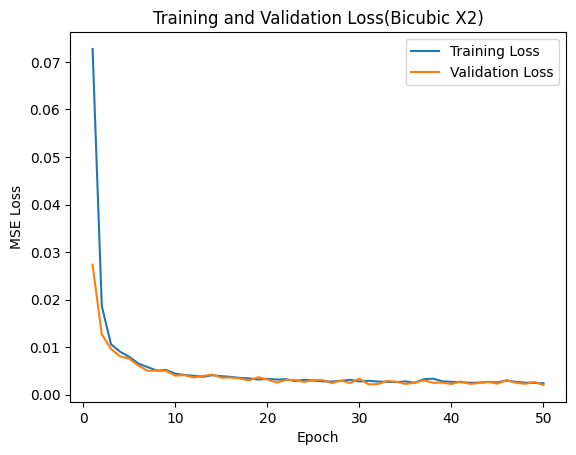

In [9]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss(Bicubic X2)')
plt.legend()
plt.show()

In [ ]:
model.